In [164]:
# import library
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

sns.set(style='darkgrid')

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

%matplotlib inline

In [3]:
# get stock info by Yahoo!Finance
# data will get from 7/31/2019 to 7/31/2020
# path
p = "/home/haininhhoang94/WSL/Projects/covid19_financial_analysis"
while True:
    try:
        nyse_hist = pd.read_csv(p + "/Data/NYSE.csv")
        break
    except FileNotFoundError:
        nyse = yf.Ticker("^NYA")
        nyse.info
        nyse_hist = nyse.history(period="365d")
        nyse_hist.to_csv(p + "/Data/NYSE.csv")

In [4]:
nyse_hist['Date']=pd.to_datetime(nyse_hist['Date'])
nyse_hist['Date']

0     2019-02-20
1     2019-02-21
2     2019-02-22
3     2019-02-25
4     2019-02-26
         ...    
360   2020-07-24
361   2020-07-27
362   2020-07-28
363   2020-07-29
364   2020-07-30
Name: Date, Length: 365, dtype: datetime64[ns]

In [21]:
# get covid-19 info
# https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/141607
# https://towardsdatascience.com/covid-19-data-collection-a-python-api-story-347aafa95e69
def covid_19_data_collection(countries=["US", "FR"]):
    import COVID19Py as cpy

    covid = cpy.COVID19(url="https://covid-tracker-us.herokuapp.com")

    for i in range(len(countries)):
        all_location_json = covid.getLocationByCountryCode(
            countries[i], timelines=True
        )[0]

        confirmed = pd.DataFrame.from_dict(
            all_location_json["timelines"]["confirmed"]["timeline"], orient="index",
        ).rename(columns={0: "{}_confirmed".format(countries[i])})

        #deaths = pd.DataFrame.from_dict(
        #    all_location_json["timelines"]["deaths"]["timeline"], orient="index",
        #).rename(columns={0: "{}_deaths".format(countries[i])})

        # recovered = pd.DataFrame.from_dict(
        #     all_location_json["timelines"]["recovered"]["timeline"], orient="index",
        # ).rename(columns={0: "{}_recovered".format(countries[i])})

        if i == 0:
            covid_df = confirmed
        else:
            covid_df = covid_df.join(confirmed)
        #covid_df = covid_df.join(deaths)
        # covid_df = covid_df.join(recovered)
    return covid_df
countries = ["US", "FR", "ES", "ZA", "BR", "RU"]
covid_df = covid_19_data_collection(countries)

In [22]:
covid_df.index=pd.to_datetime(covid_df.index).date
covid_df.index

Index([2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-01-26, 2020-01-27,
       2020-01-28, 2020-01-29, 2020-01-30, 2020-01-31,
       ...
       2020-07-23, 2020-07-24, 2020-07-25, 2020-07-26, 2020-07-27, 2020-07-28,
       2020-07-29, 2020-07-30, 2020-07-31, 2020-08-01],
      dtype='object', length=193)

In [23]:
# get unployment rate US information
# https://www.bls.gov/developers/api_python.htm
# Unemployment Rate - LNS14000000
# Discouraged Workers - LNU05026645
# Persons At Work Part Time for Economic Reasons - LNS12032194
# Unemployment Rate - 25 Years & Over, Some College or Associate Degree - LNS14027689
def unemployment_rate(start_year=2019, end_year=2020):
    import requests
    import json

    headers = {"Content-type": "application/json"}
    data = json.dumps(
        {
            "seriesid": ["LNS14000000"],
            "startyear": "{}".format(start_year),
            "endyear": "{}".format(end_year),
        }
    )
    p = requests.post(
        "https://api.bls.gov/publicAPI/v2/timeseries/data/", data=data, headers=headers
    )
    json_data = json.loads(p.text)
    result = pd.DataFrame.from_dict(json_data["Results"]["series"][0]["data"])
    return result

In [127]:
unemployment_df = unemployment_rate(start_year=2015, end_year=2020).drop(columns='footnotes')

In [128]:
unemployment_df

,year,period,periodName,latest,value
0,2020,M06,June,true,11.1
1,2020,M05,May,NaN,13.3
2,2020,M04,April,NaN,14.7
3,2020,M03,March,NaN,4.4
4,2020,M02,February,NaN,3.5
...,...,...,...,...,...
61,2015,M05,May,NaN,5.6
62,2015,M04,April,NaN,5.4
63,2015,M03,March,NaN,5.4
64,2015,M02,February,NaN,5.5


In [129]:
s = "8 March, 2017"
d = datetime.strptime(s, '%d %B, %Y')
print(d.strftime('%Y-%m-%d'))

2017-03-08


In [130]:
unemployment_df['Date'] = unemployment_df['year'] +  '-' + unemployment_df['periodName'] + '-' + '01'
unemployment_df['Date'] = pd.to_datetime(unemployment_df['Date'], format='%Y-%B-%d')
unemployment_df.set_index('Date', inplace=True)
unemployment_df.head()
#d = datetime.strptime(s, '%Y-%B-%d')
#print(d.strftime('%Y-%m-%d'))

,year,period,periodName,latest,value
Date,,,,,
2020-06-01,2020,M06,June,true,11.1
2020-05-01,2020,M05,May,NaN,13.3
2020-04-01,2020,M04,April,NaN,14.7
2020-03-01,2020,M03,March,NaN,4.4
2020-02-01,2020,M02,February,NaN,3.5


In [131]:
# Get business cycle:
# Business cycle is the data/graph of movement in GDP around its long-term growth trend
# https://codingandfun.com/economic-indicators-with-python/
def checkindicator(url):
    import requests
    import json
    r= requests.get(url)
    r = r.json()
    periods = r['series']['docs'][0]['period']
    values = r['series']['docs'][0]['value']
    dataset = r['series']['docs'][0]['dataset_name']

    indicators = pd.DataFrame(values,index=periods)
    indicators.columns = [dataset]
    return indicators   

In [132]:
GDPgrowth = checkindicator('https://api.db.nomics.world/v22/series/WB/WDI/NY.GDP.MKTP.KD.ZG-EU?observations=1')

# Visualize the data
NYSE price from 2019 to 2020

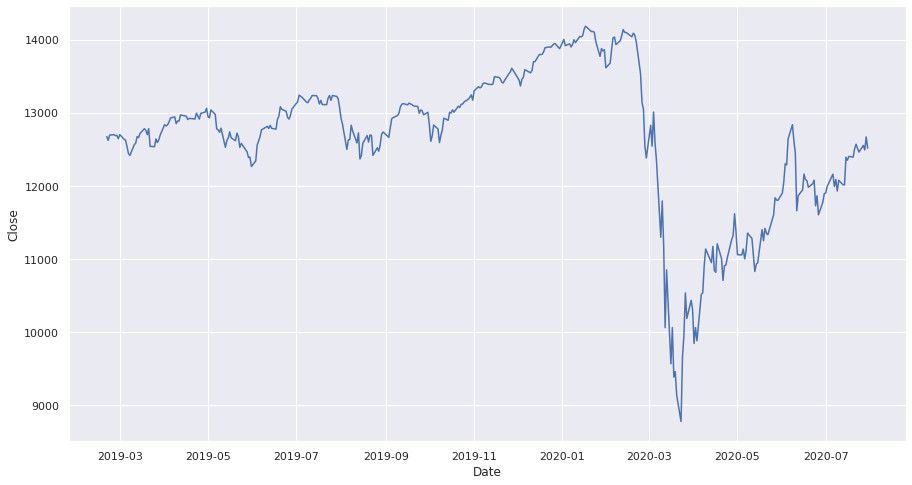

In [60]:
#plt.figure(figsize=(15,8))
nyse_plot = sns.lineplot(x="Date", y="Close",data=nyse_hist)

No handles with labels found to put in legend.


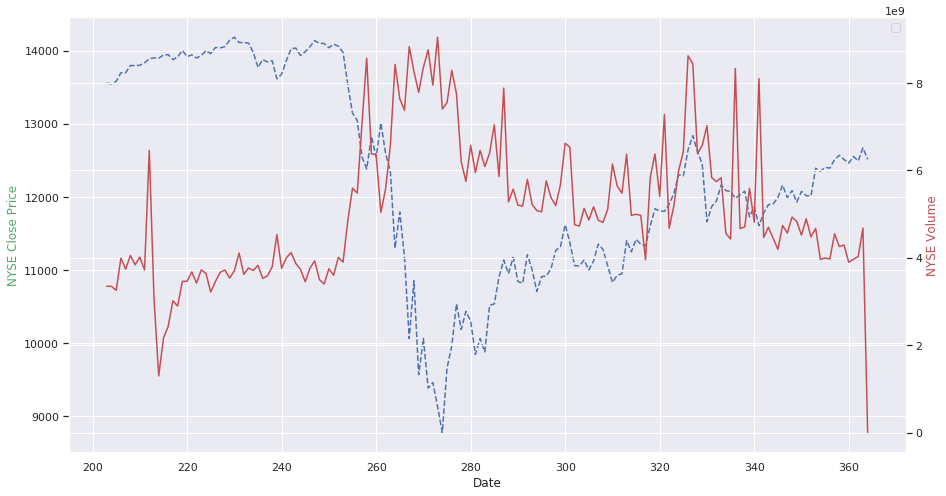

In [170]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(nyse_hist['Close'].loc['2020-02-01':], '--b', label='NYSE')
ax2.plot(nyse_hist['Volume'].loc['2020-02-01':],'-r')

ax1.set_xlabel('Date')
ax1.set_ylabel('NYSE Close Price', color='g')
ax2.set_ylabel('NYSE Volume', color='r')

plt.legend()
plt.show()

COVID-19 Infection Rate

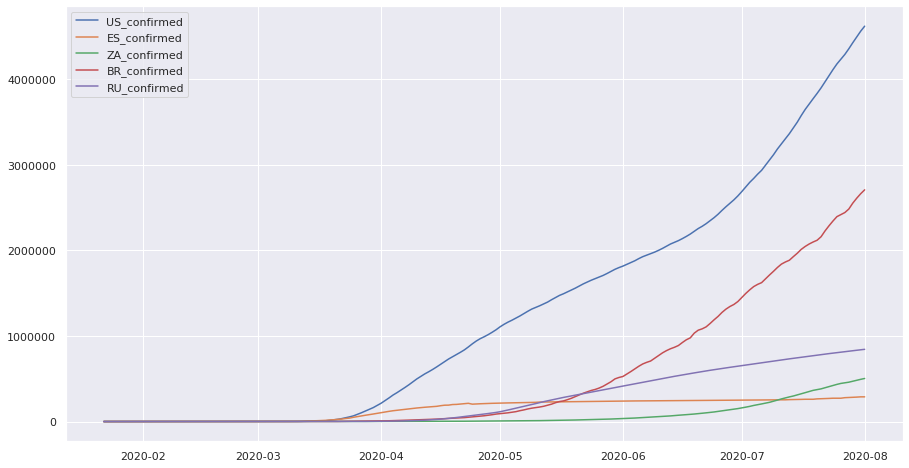

In [59]:
#plt.figure(figsize=(15,8))
covid_plot = sns.lineplot(data=covid_df.drop(columns='FR_confirmed'), dashes=False)

## Combine graph

In [35]:
nyse_hist_close = nyse_hist.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits']).set_index('Date')
combined_df = nyse_hist_close.join(covid_df)
combined_df.head()

,Close,US_confirmed,FR_confirmed,ES_confirmed,ZA_confirmed,BR_confirmed,RU_confirmed
Date,,,,,,,
2019-02-20,12673.66,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-21,12621.77,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-22,12694.52,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-25,12700.19,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-26,12686.56,NaN,NaN,NaN,NaN,NaN,NaN


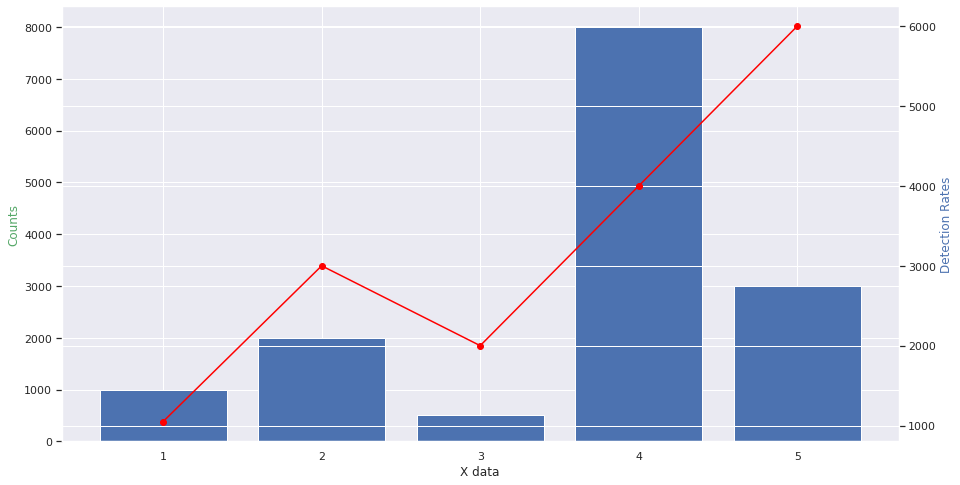

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

x = [1,2,3,4,5]
y = [1000,2000,500,8000,3000]
y1 = [1050,3000,2000,4000,6000]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(x, y)
ax2.plot(x, y1, 'o-', color="red" )

ax1.set_xlabel('X data')
ax1.set_ylabel('Counts', color='g')
ax2.set_ylabel('Detection Rates', color='b')

plt.show()

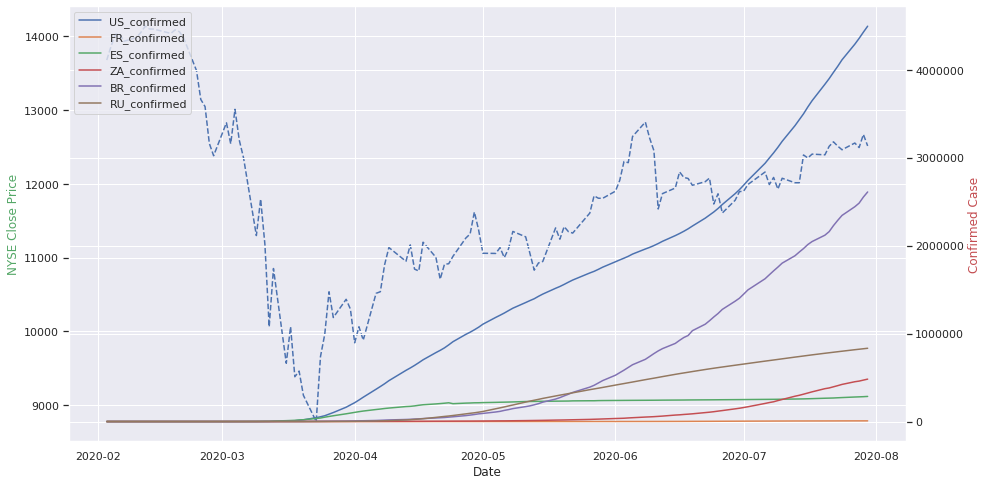

In [93]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(combined_df['Close'].loc['2020-02-01':], '--b', label='NYSE')
ax2.plot(combined_df.drop(columns='Close').loc['2020-02-01':])

ax1.set_xlabel('Date')
ax1.set_ylabel('NYSE Close Price', color='g')
ax2.set_ylabel('Confirmed Case', color='r')

plt.legend(combined_df.drop(columns='Close').columns.values)
plt.show()

Clearly see a prediction/panic mode in NYSE before the first case in Covid-19 happened

In [142]:
unemployment_df.head()
combined_df_2 = combined_df.join(unemployment_df).drop(columns=['year', 'period', 'periodName','latest'])

In [158]:
combined_df_2 = combined_df_2.dropna().rename(columns={'value': 'Unployment Rate'})
combined_df_2

,Close,US_confirmed,FR_confirmed,ES_confirmed,ZA_confirmed,BR_confirmed,RU_confirmed,Unployment Rate
Date,,,,,,,,
2020-04-01,9844.85,214205.0,51.0,104118.0,1380.0,6836.0,2777.0,14.7
2020-05-01,11058.57,1106829.0,128.0,215216.0,5951.0,92202.0,114431.0,13.3
2020-06-01,11900.24,1816479.0,499.0,239638.0,34357.0,526447.0,414328.0,11.1


Graph a chart plot to analyze the unemployment rate

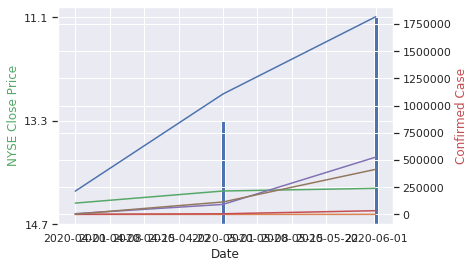

In [162]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(combined_df_2.index.values, combined_df_2['Unployment Rate'])
ax2.plot(combined_df_2.index.values, combined_df_2.drop(columns=['Close','Unployment Rate']))

ax1.set_xlabel('Date')
ax1.set_ylabel('NYSE Close Price', color='g')
ax2.set_ylabel('Confirmed Case', color='r')

#plt.legend(combined_df.drop(columns='Close').columns.values)
plt.show()

NYSE predict the unemployment and GDP

## ACF and PACF

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf()